## DCGAN Tutorial!

* 참고: [논문](https://arxiv.org/pdf/1511.06434.pdf)

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

generator에서 `tanh`를 activation으로 활용합니다.

`tanh`를 활용하면 output이 -1 ~ 1 사이로 나오기 때문에 **Normalize**를 해줄 때 127.5로 나눈 뒤 1을 빼줍니다.

In [4]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

**min** 값과 **max** 값이 -1 ~ 1사이의 범위를 가져야 합니다.

In [5]:
x_train.min(), x_train.max()

(-1.0, 1.0)

`x_train` 값은 현재 28 * 28로 되어 있습니다.

이번에는 **Conv2D Layer를 활용**하여 모델을 빌드업하기 때문에 별도로 Flatten 이 필요 없습니다.

다만, channel을 1 추가하기 위한 `reshape`를 진행합니다.

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)

필요한 모듈을 import 합니다.

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, BatchNormalization, Reshape, Conv2D, Conv2DTranspose, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

## Hyperparameters

`NOISE_DIM`을 정의 합니다.

NOISE_DIM은 자유롭게 설정할 수 있으며, generator의 **input**으로 들어갑니다.

In [8]:
# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 100

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
adam = Adam(lr=0.0002, beta_1=0.5)

## Generator

generator를 정의합니다.

In [9]:
generator = Sequential([
    Dense(256 * 7 * 7, input_dim=NOISE_DIM), 
    LeakyReLU(alpha=0.01), 
    Reshape((7, 7, 256)), 
    Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'), 
    BatchNormalization(), 
    LeakyReLU(alpha=0.01), 
    Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'),
    BatchNormalization(), 
    LeakyReLU(alpha=0.01), 
    Conv2D(1, kernel_size=3, padding='same'),
    Activation('tanh'),
])

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        7

## Discriminator

discriminator를 정의합니다.

In [11]:
discriminator = Sequential([
    Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1)), 
    LeakyReLU(alpha=0.01), 
    Dropout(0.25),
    Conv2D(64, kernel_size=3, strides=2, padding='same'), 
    LeakyReLU(alpha=0.01), 
    Conv2D(128, kernel_size=3, strides=2, padding='same'), 
    LeakyReLU(alpha=0.01), 
    Dropout(0.25),
    Flatten(), 
    Dense(1, activation='sigmoid'),
])

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 128)        

반드시 dicriminator를 **compile** 해주어야 합니다.

In [13]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

## Gan

generator와 discriminator를 연결합니다.

In [14]:
# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 합니다.
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

gan 모델을 정의합니다.

In [15]:
gan = Model(gan_input, output)

In [16]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         1637121   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 94721     
Total params: 1,731,842
Trainable params: 1,636,737
Non-trainable params: 95,105
_________________________________________________________________


## Compile

In [17]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

## Batch

이미지 batch를 생성합니다. MNIST 이미지 batch가 차례대로 생성됩니다.

In [18]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

##  시각화를 위한 유틸 함수 정의

In [19]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## 학습

In [20]:
BATCH_SIZE = 128
EPOCHS= 100

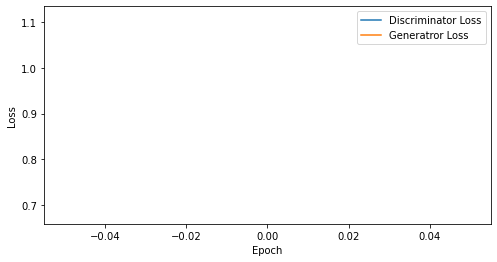

epoch: 1, Discriminator Loss: 0.6807432770729065, Generator Loss: 1.112392544746399


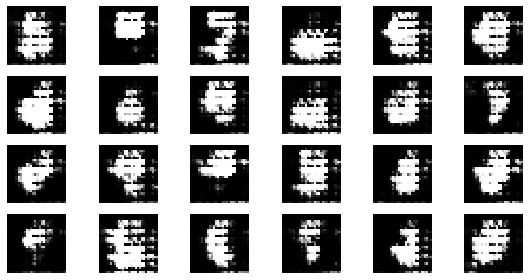

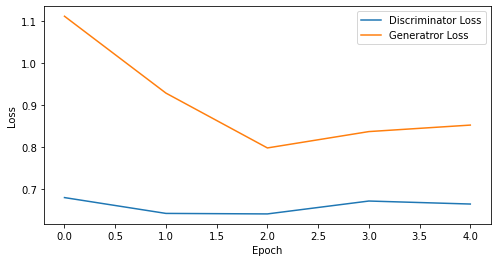

epoch: 5, Discriminator Loss: 0.6607211470603943, Generator Loss: 0.9063739895820617


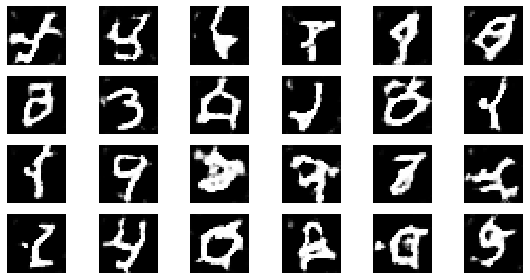

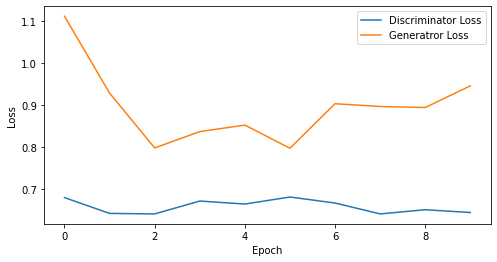

epoch: 10, Discriminator Loss: 0.6592484414577484, Generator Loss: 0.8973466277122497


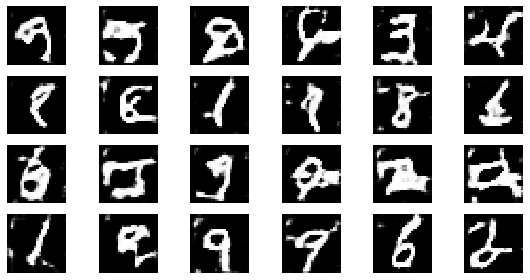

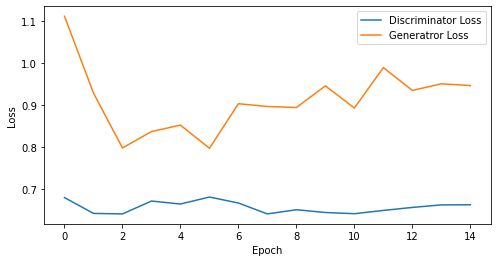

epoch: 15, Discriminator Loss: 0.6579542716344198, Generator Loss: 0.9128210624059041


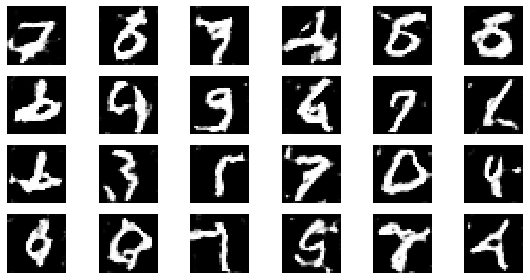

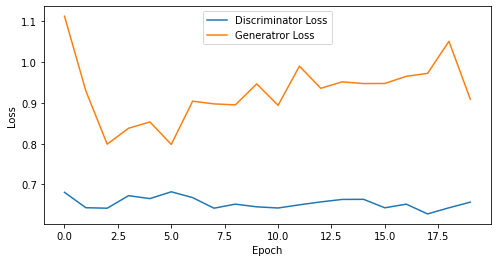

epoch: 20, Discriminator Loss: 0.6545710951089859, Generator Loss: 0.9268746197223663


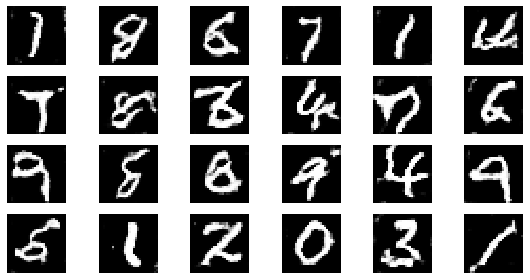

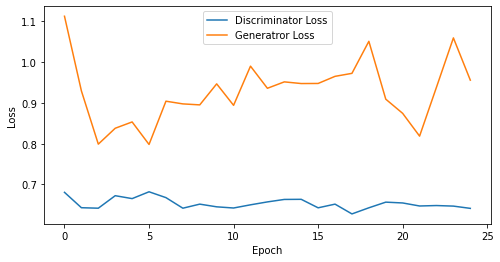

epoch: 25, Discriminator Loss: 0.6532119941711426, Generator Loss: 0.9273580455780029


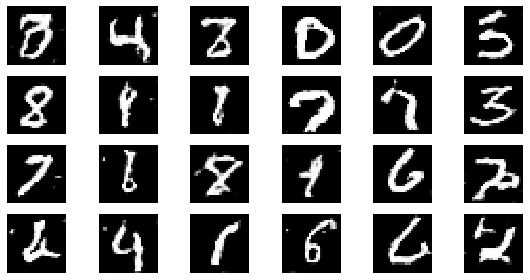

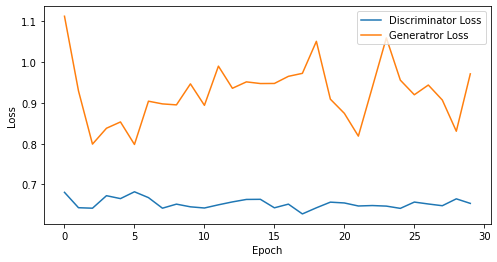

epoch: 30, Discriminator Loss: 0.653528877099355, Generator Loss: 0.9252141276995342


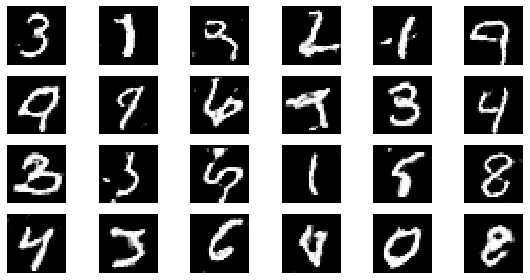

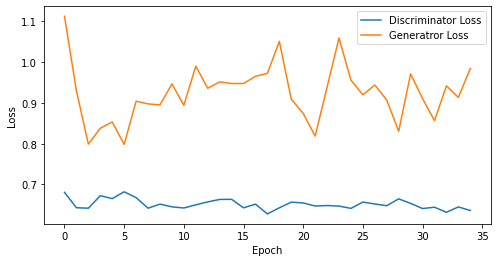

epoch: 35, Discriminator Loss: 0.6515492507389613, Generator Loss: 0.9246604408536638


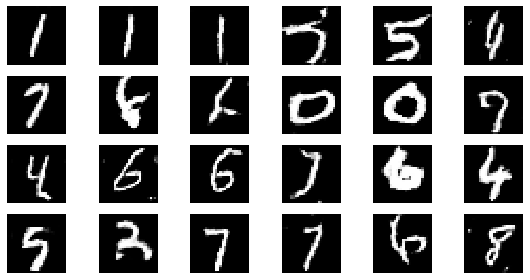

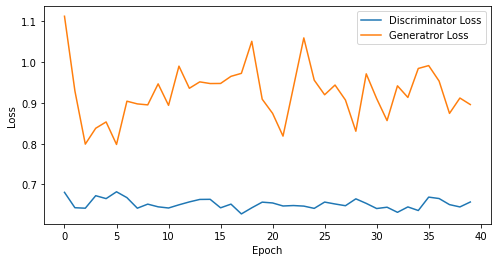

epoch: 40, Discriminator Loss: 0.6522895067930221, Generator Loss: 0.9247547268867493


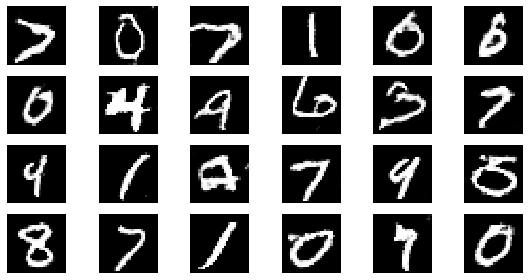

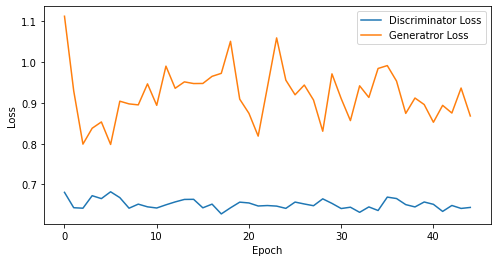

epoch: 45, Discriminator Loss: 0.6513466782040066, Generator Loss: 0.9203588724136352


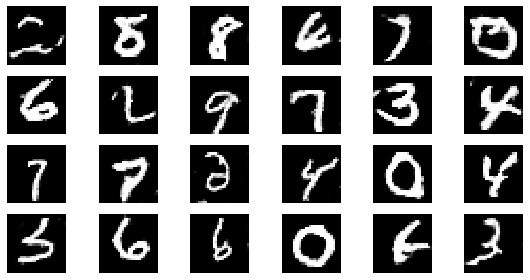

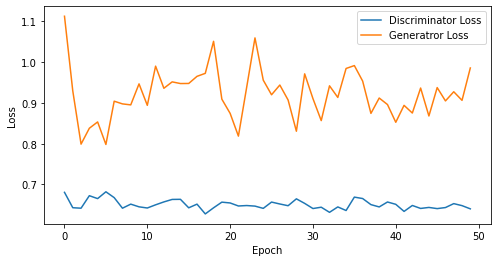

epoch: 50, Discriminator Loss: 0.6507298994064331, Generator Loss: 0.9215528202056885


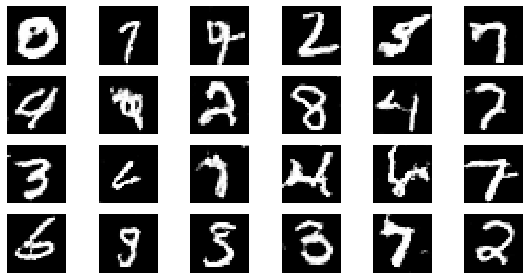

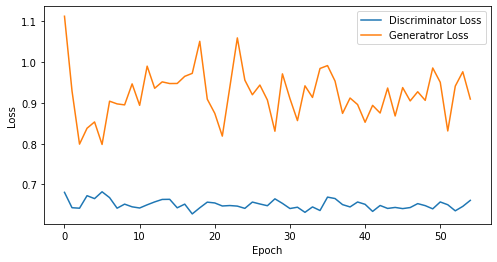

epoch: 55, Discriminator Loss: 0.6506722276861018, Generator Loss: 0.9215677727352489


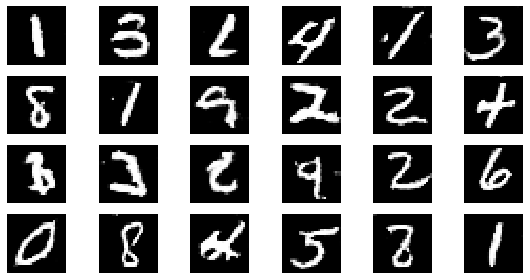

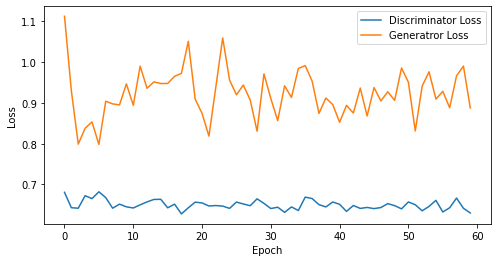

epoch: 60, Discriminator Loss: 0.6500181138515473, Generator Loss: 0.9224448084831238


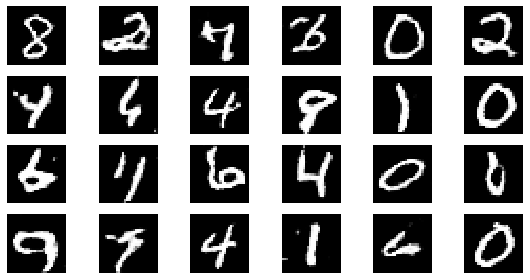

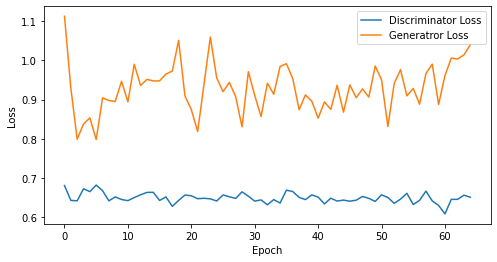

epoch: 65, Discriminator Loss: 0.6493555032289945, Generator Loss: 0.9287787052301261


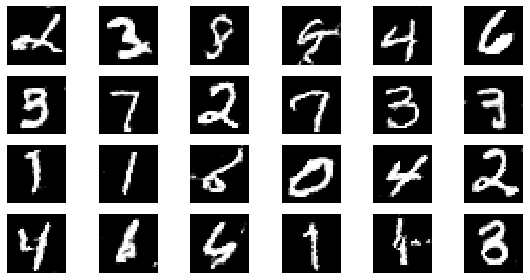

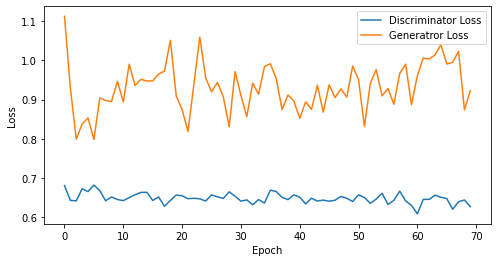

epoch: 70, Discriminator Loss: 0.6483784283910479, Generator Loss: 0.9310754903725216


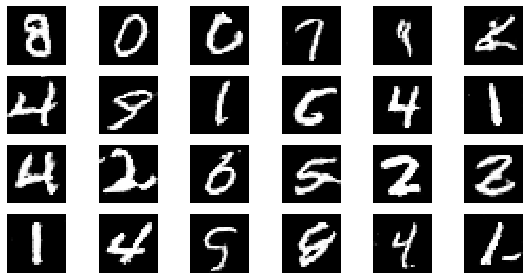

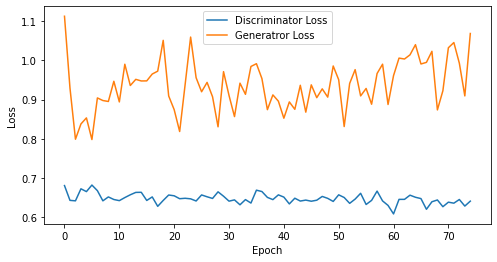

epoch: 75, Discriminator Loss: 0.6476769971847535, Generator Loss: 0.9363076686859131


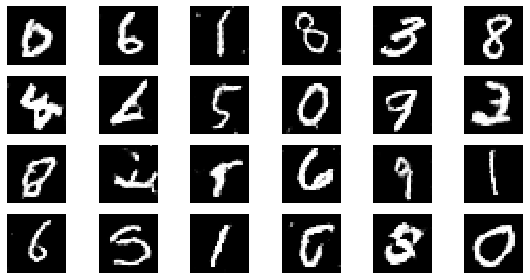

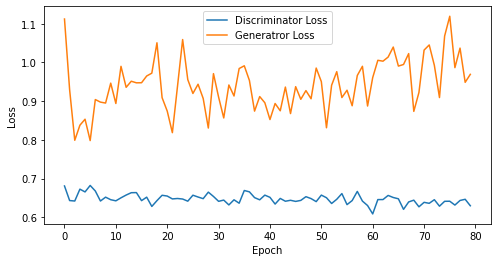

epoch: 80, Discriminator Loss: 0.6470974780619144, Generator Loss: 0.9410562165081501


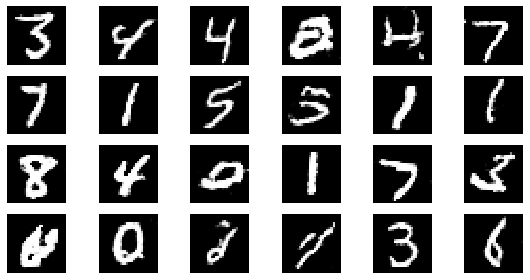

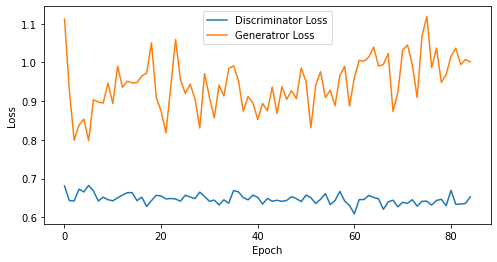

epoch: 85, Discriminator Loss: 0.6469738714835223, Generator Loss: 0.9451834335046656


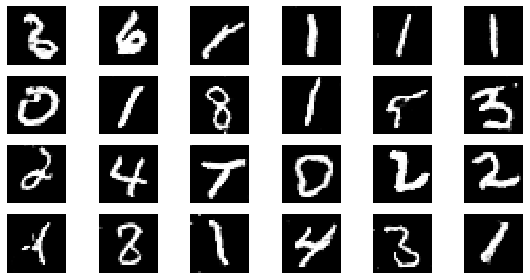

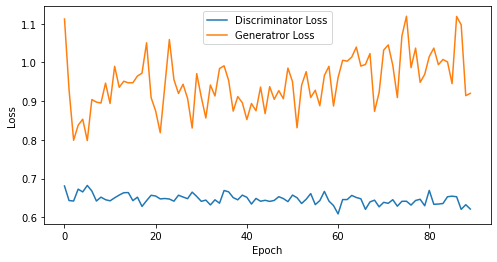

epoch: 90, Discriminator Loss: 0.646375819047292, Generator Loss: 0.9481856160693698


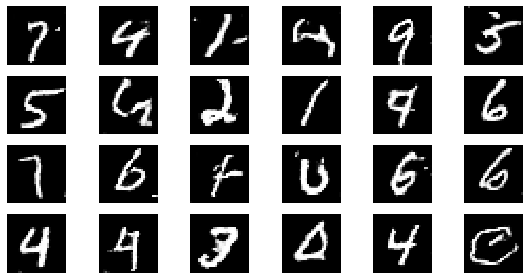

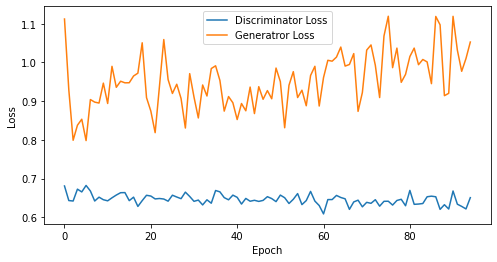

epoch: 95, Discriminator Loss: 0.6460549981970536, Generator Loss: 0.9529305414149636


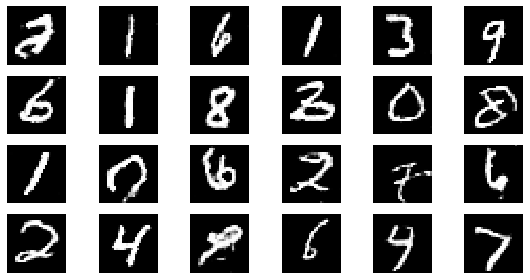

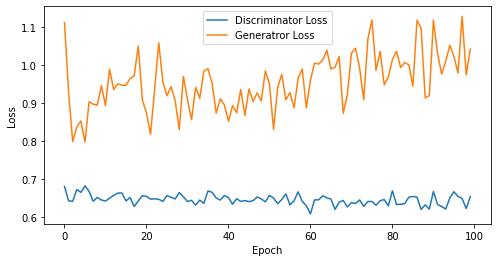

epoch: 100, Discriminator Loss: 0.6462258183956147, Generator Loss: 0.9567907959222793


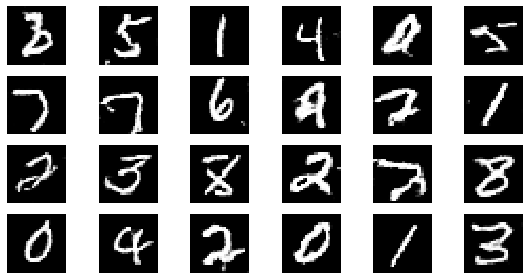

In [21]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)